# Partially Monotonic Neural Network - Daniels, Velikova 2010

The paper "Monotone and Partially Monotone Neural Networks" by Daniels and Velikova proposes a novel approach to constructing neural networks with monotonicity constraints. Monotonicity is an important property for many real-world applications, such as in finance or healthcare, where inputs and outputs are expected to have a certain relationship.

The authors address the challenge of designing neural networks that maintain monotonicity, which is particularly difficult when dealing with non-linear activation functions. They introduce a new class of activation functions, called partially monotone activation functions, which can ensure monotonicity in certain parts of the input space. They also provide a practical algorithm for training these networks efficiently. 

Overall, the paper presents an innovative and practical solution to an important problem in the field of machine learning.


![](partmonNN.png)

Paper: Daniels H, Velikova M. Monotone and partially monotone neural networks. IEEE Trans Neural Netw. 2010 Jun;21(6):906-17. doi: 10.1109/TNN.2010.2044803. Epub 2010 Apr 5. PMID: 20371402.

## 0. Library imports

In [1]:
# linear algebra
import math
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# display
from torchview import draw_graph
from IPython.display import display
from IPython.core.display import SVG, HTML

# plot
import matplotlib.pyplot as plt
import matplotlib

# progress bar
from tqdm import tqdm

# model
from models.partmonNN import MonotonicNet

# functions
from functions import *

# support for automatic reloading
%load_ext autoreload
%autoreload 2

In [2]:
# make this work

# # Set random seed
# torch.manual_seed(42)
# np.random.seed(42)

# # Set device
# if (int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13) and torch.has_mps:
#     device = torch.device("mps")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

# # Set matplotlib style
# matplotlib.rcParams["figure.dpi"] = 200
# matplotlib.rcParams["font.size"] = 8

## 1. Function Examples

Let's apply the Monotone and Partially Monotone Neural Network on different toy functions which have different properties: monotnic increasing/decreasing, 1D/2D, non-monotonic.

### $f_1(x) = (x+1)^2$ monotonic increasing in $x$

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/2770338551.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z1_tensor = torch.tensor(f1(X_tensor_f1)).float()


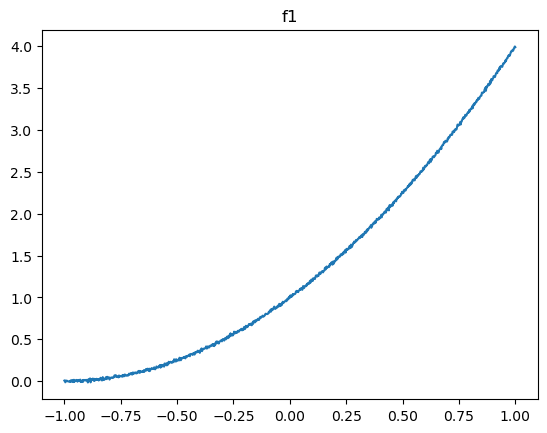

In [3]:
# define space
X_tensor_f1 = torch.linspace(-1, 1, 1000).float()
Z1_tensor = torch.tensor(f1(X_tensor_f1)).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f1.cpu().detach(), Z1_tensor.cpu().detach(), label='f1')
plt.title('f1')
plt.show()

In [4]:
# NN parameters
n_features_in = 1 # only one variable
group_sizes = [2, 4, 4, 2] # number of neurons in each group
increasing_bool = [True] # increasing or decreasing
monotonic_bool = [True] # monotonic or not

# initial learning rate
LR = 1e-2

# defining the model
model_f1 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f1 = nn.MSELoss()
optimizer_f1 = torch.optim.Adam(model_f1.parameters(), lr=LR)
scheduler_f1 = torch.optim.lr_scheduler.StepLR(optimizer_f1, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f1.shape[0]

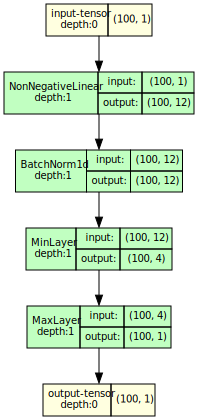

In [5]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f1, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="PMonNN_graph_f1", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [6]:
# training loop
EPOCHS = 200
BATCH_SIZE = 10

losses_f1 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f1.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_f1[idx], Z1_tensor[idx]

        # zero grad
        optimizer_f1.zero_grad()

        # forward pass
        output = model_f1(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f1(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f1.step()

    # update LR
    scheduler_f1.step()

    losses_f1.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f1[-1]:.7f} - LR {optimizer_f1.param_groups[0]['lr']:.7f}")
    

Epoch 199: 100%|██████████| 200/200 [00:23<00:00,  8.49it/s, Loss 0.1698238 - LR 0.0056250]


Epoch 200 - train loss: 0.16982377774780616
Epoch 200 - test loss: 303.275634765625


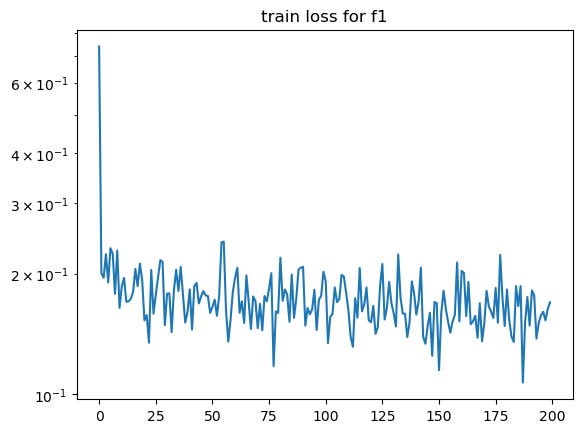

In [7]:
# prediction
with torch.no_grad():
    model_f1.eval()
    y_pred = model_f1(X_tensor_f1.unsqueeze(1))

final_loss = criterion_f1(y_pred, Z1_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f1[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f1, label='train loss')
plt.yscale('log')
plt.title('train loss for f1')
plt.savefig('figures/PmonNN_train_loss_f1.png')
plt.show()

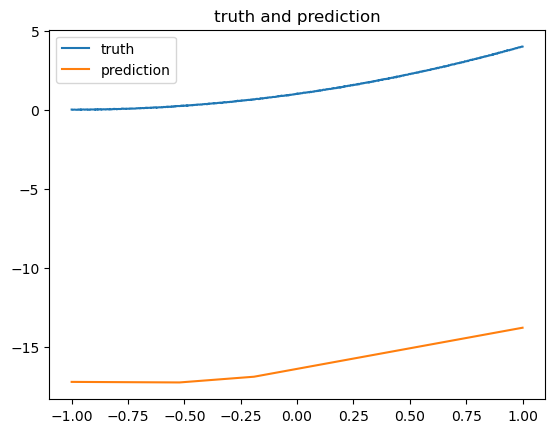

In [8]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f1, Z1_tensor, label='truth')
plt.plot(X_tensor_f1, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/PMonNN_truth_prediction_f1.png')
plt.show()

### 2.2 $f_2(x) = -(x+1)^2$: monotonic decreasing in $x$

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/1942353590.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z2_tensor = torch.tensor(f2(X_tensor_f2)).float()


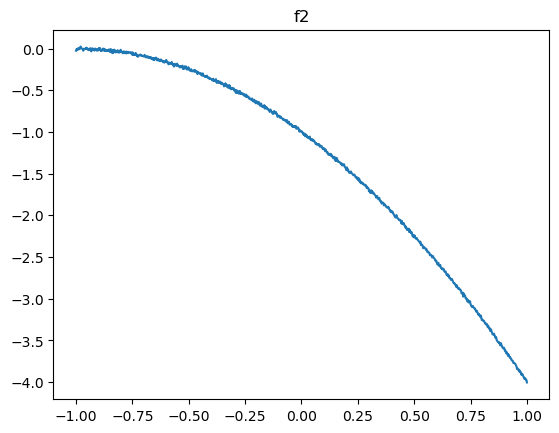

In [9]:
# define space
X_tensor_f2 = torch.linspace(-1, 1, 1000).float()
Z2_tensor = torch.tensor(f2(X_tensor_f2)).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f2.cpu().detach(), Z2_tensor.cpu().detach(), label='f2')
plt.title('f2')
# plt.savefig('figures/f2.png')
plt.show()

In [10]:
# NN parameters
n_features_in = 1 # only one variable
group_sizes = [2, 4, 4, 2] # number of neurons in each group
increasing_bool = [False] # increasing or decreasing
monotonic_bool = [True] # monotonic or not

# initial learning rate
LR = 1e-2

# defining the model
model_f2 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f2 = nn.MSELoss()
optimizer_f2 = torch.optim.Adam(model_f2.parameters(), lr=LR)
scheduler_f2 = torch.optim.lr_scheduler.StepLR(optimizer_f2, step_size=50, gamma=0.75)

n_samples_train = X_tensor_f2.shape[0]

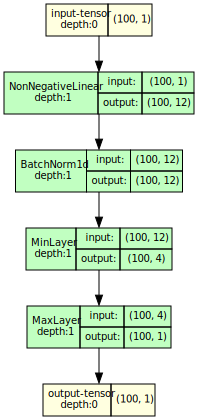

In [11]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f2, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="PMonNN_graph_f2", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [12]:
# training loop
EPOCHS = 200
BATCH_SIZE = 10

losses_f2 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f2.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_f2[idx], Z2_tensor[idx]

        # zero grad
        optimizer_f2.zero_grad()

        # forward pass
        output = model_f2(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f2(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f2.step()

    # update LR
    scheduler_f2.step()

    losses_f2.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f2[-1]:.7f} - LR {optimizer_f2.param_groups[0]['lr']:.7f}")
    

Epoch 199: 100%|██████████| 200/200 [00:30<00:00,  6.55it/s, Loss 0.1732338 - LR 0.0031641]


Epoch 200 - train loss: 0.173233773810789
Epoch 200 - test loss: 0.9219410419464111


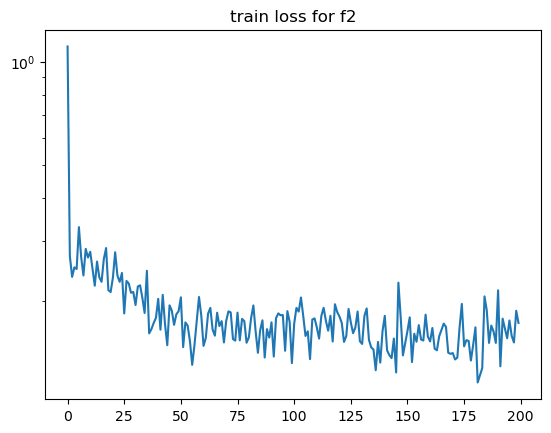

In [13]:
# prediction
with torch.no_grad():
    model_f2.eval()
    y_pred = model_f2(X_tensor_f2.unsqueeze(1))

final_loss = criterion_f2(y_pred, Z2_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f2[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f2, label='train loss')
plt.yscale('log')
plt.title('train loss for f2')
plt.savefig('figures/PMonNN_train_loss_f2.png')
plt.show()

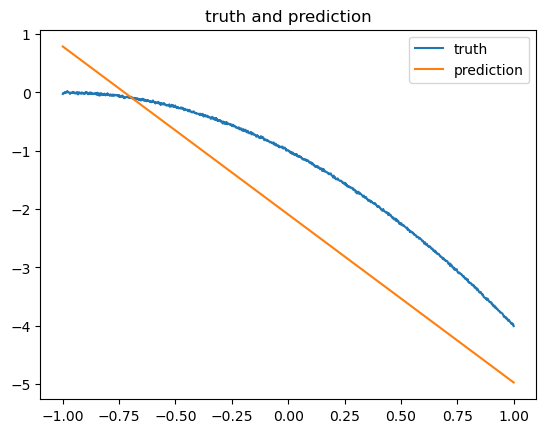

In [14]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f2, Z2_tensor, label='truth')
plt.plot(X_tensor_f2, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/PMonNN_truth_prediction_f2.png')
plt.show()

### 2.3 $f_3(x, y) = x+y$: monotonic increasing in $x$ and $y$

/Users/ncarmona/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/2163196853.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z3_tensor_2D = torch.tensor(f3(X_tensor_f3_2D, Y_tensor_f3_2D))
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/2163196853.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

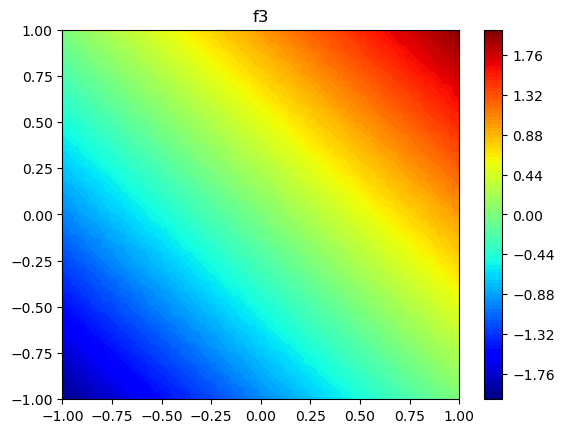

In [15]:
# define space
X_tensor_f3 = torch.linspace(-1, 1, 100)
Y_tensor_f3 = torch.linspace(-1, 1, 100)
X_tensor_f3_2D, Y_tensor_f3_2D = torch.meshgrid(X_tensor_f3, Y_tensor_f3)
Z3_tensor_2D = torch.tensor(f3(X_tensor_f3_2D, Y_tensor_f3_2D))

X_tensor_2d = torch.cat((X_tensor_f3_2D.unsqueeze(2), Y_tensor_f3_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z3_tensor = torch.tensor(Z3_tensor_2D.ravel()).float()

plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, Z3_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f3')
# plt.savefig('figures/f3.png')
plt.show()

In [16]:
# NN parameters
n_features_in = 2 # 2 variables in input
group_sizes = [4, 8, 8, 4] # number of neurons in each group
increasing_bool = [True, True] # increasing or decreasing
monotonic_bool = [True, True] # monotonic or not

# initial learning rate
LR = 1e-2

# defining the model
model_f3 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f3 = nn.MSELoss()
optimizer_f3 = torch.optim.Adam(model_f3.parameters(), lr=LR)
scheduler_f3 = torch.optim.lr_scheduler.StepLR(optimizer_f3, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

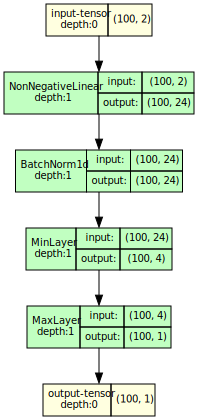

In [17]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f3, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="PMonNN_graph_f3", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [18]:
# training loop
EPOCHS = 600
BATCH_SIZE = 256

losses_f3 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f3.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_2d[idx], Z3_tensor[idx]

        # zero grad
        optimizer_f3.zero_grad()

        # forward pass
        output = model_f3(batch_x)

        # compute loss
        loss = criterion_f3(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f3.step()

    # update LR
    scheduler_f3.step()

    losses_f3.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f3[-1]:.7f} - LR {optimizer_f3.param_groups[0]['lr']:.7f}")
    

Epoch 599: 100%|██████████| 600/600 [00:48<00:00, 12.28it/s, Loss 0.0040222 - LR 0.0017798]


Epoch 600 - train loss: 0.004022227703535464
Epoch 600 - test loss: 0.000272762292297557


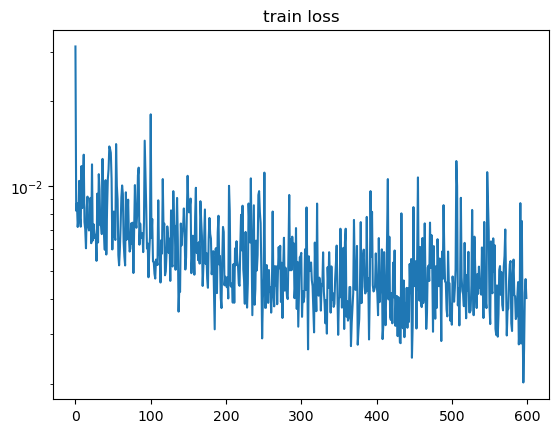

In [19]:
# prediction
with torch.no_grad():
    model_f3.eval()
    y_pred = model_f3(X_tensor_2d)

final_loss = criterion_f3(y_pred, Z3_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f3[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f3, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/PMonNN_train_loss_f3.png')
plt.show()

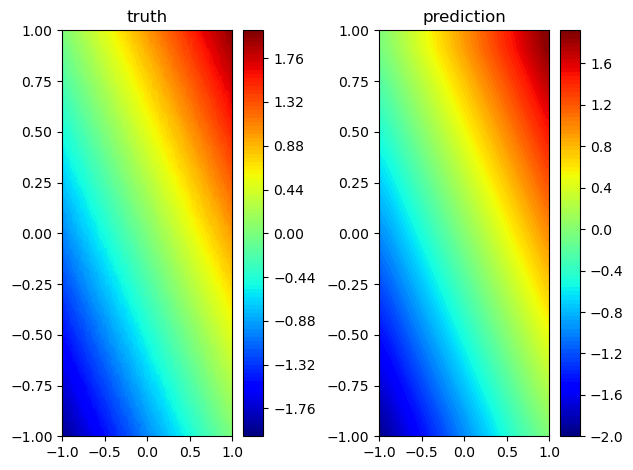

In [20]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, Z3_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/PMonNN_truth_prediction_f3.png')
plt.show()

### 2.4 $f_4(x, y) = x-y$: monotonic increasing in $x$, decreasing in $y$ 

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/4011485104.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z4_tensor_2D = torch.tensor(f4(X_tensor_f4_2D, Y_tensor_f4_2D))
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/4011485104.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z4_tensor = torch.tensor(Z4_tensor_2D.ravel()).float()


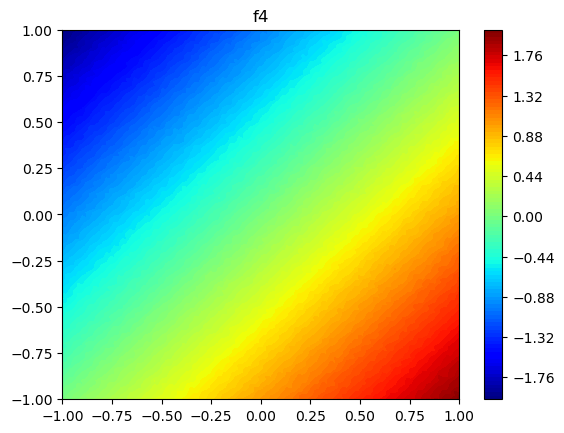

In [21]:
# define space
X_tensor_f4 = torch.linspace(-1, 1, 100)
Y_tensor_f4 = torch.linspace(-1, 1, 100)
X_tensor_f4_2D, Y_tensor_f4_2D = torch.meshgrid(X_tensor_f4, Y_tensor_f4)
Z4_tensor_2D = torch.tensor(f4(X_tensor_f4_2D, Y_tensor_f4_2D))

X_tensor_2d = torch.cat((X_tensor_f4_2D.unsqueeze(2), Y_tensor_f4_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z4_tensor = torch.tensor(Z4_tensor_2D.ravel()).float()

plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, Z4_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f4')
# plt.savefig('figures/f4.png')
plt.show()

In [22]:
# NN parameters
n_features_in = 2 # 2 variables in input
group_sizes = [4, 8, 8, 4] # number of neurons in each group
increasing_bool = [True, False] # increasing or decreasing
monotonic_bool = [True, True] # monotonic or not

# initial learning rate
LR = 1e-2

# defining the model
model_f4 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f4 = nn.MSELoss()
optimizer_f4 = torch.optim.Adam(model_f4.parameters(), lr=LR)
scheduler_f4 = torch.optim.lr_scheduler.StepLR(optimizer_f4, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

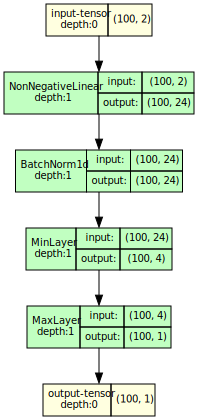

In [23]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f4, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="PMonNN_graph_f4", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [24]:
# training loop
EPOCHS = 500
BATCH_SIZE = 256

losses_f4 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f4.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_2d[idx], Z4_tensor[idx]

        # zero grad
        optimizer_f4.zero_grad()

        # forward pass
        output = model_f4(batch_x)

        # compute loss
        loss = criterion_f4(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f4.step()

    # update LR
    scheduler_f4.step()

    losses_f4.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f4[-1]:.7f} - LR {optimizer_f4.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:36<00:00, 13.62it/s, Loss 0.0053016 - LR 0.0023730]


Epoch 500 - train loss: 0.005301611497998238
Epoch 500 - test loss: 0.00031352887162938714


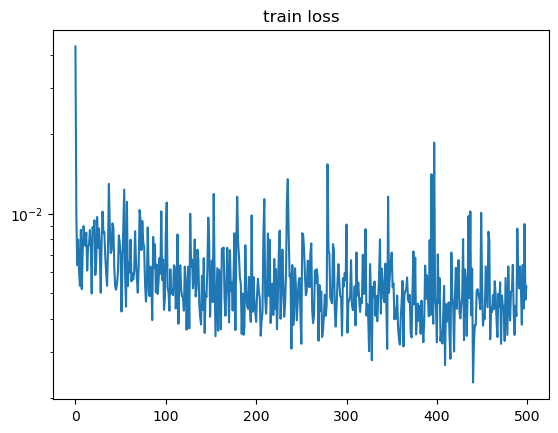

In [25]:
# prediction
with torch.no_grad():
    model_f4.eval()
    y_pred = model_f4(X_tensor_2d)

final_loss = criterion_f4(y_pred, Z4_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f4[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f4, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/PMonNN_train_loss_f4.png')
plt.show()

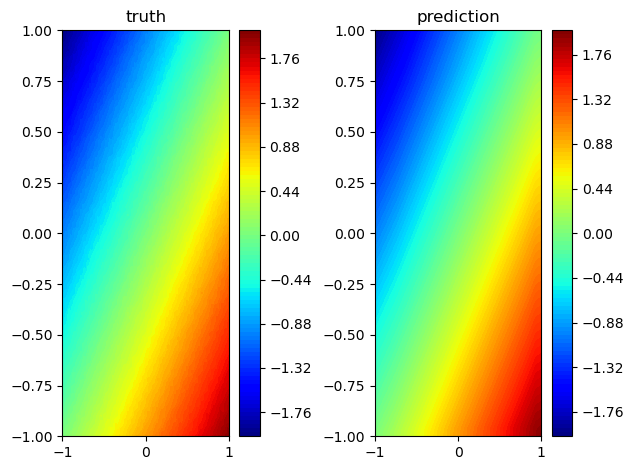

In [26]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, Z4_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/PMonNN_truth_prediction_f4.png')

plt.show()

### 2.5 $f_5(x) = cos(x)$: non-monotonic but concave

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/1293730884.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z5_tensor = torch.tensor(f5(X_tensor_f5)).float()


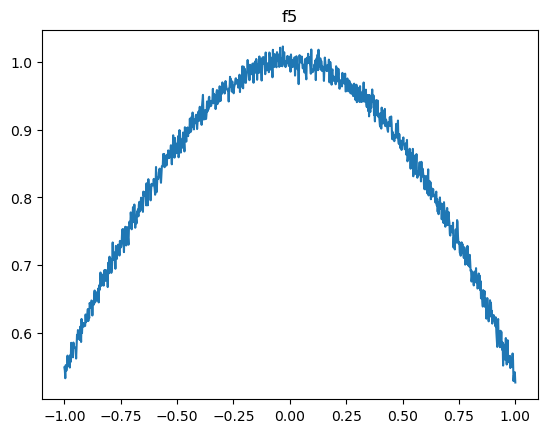

In [27]:
# define space
X_tensor_f5 = torch.linspace(-1, 1, 1000).float()
Z5_tensor = torch.tensor(f5(X_tensor_f5)).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f5.cpu().detach(), Z5_tensor.cpu().detach(), label='f5')
plt.title('f5')
# plt.savefig('figures/f5.png')
plt.show()

In [28]:
# NN parameters
n_features_in = 1 # only one variable
group_sizes = [4, 8, 8, 4] # number of neurons in each group
increasing_bool = [None] # increasing or decreasing
monotonic_bool = [False] # monotonic or not

# initial learning rate
LR = 1e-2

# defining the model
model_f5 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f5 = nn.MSELoss()
optimizer_f5 = torch.optim.Adam(model_f5.parameters(), lr=LR)
scheduler_f5 = torch.optim.lr_scheduler.StepLR(optimizer_f5, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f5.shape[0]

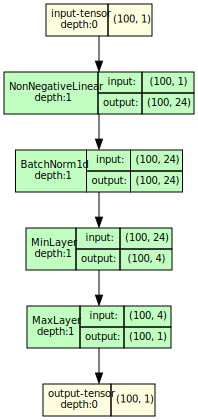

In [29]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f5, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="PMonNN_graph_f5", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [30]:
# training loop
EPOCHS = 500
BATCH_SIZE = 10

losses_f5 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f5.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_f5[idx], Z5_tensor[idx]

        # zero grad
        optimizer_f5.zero_grad()

        # forward pass
        output = model_f5(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f5(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f5.step()

    # update LR
    scheduler_f5.step()

    losses_f5.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f5[-1]:.7f} - LR {optimizer_f5.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [01:12<00:00,  6.86it/s, Loss 0.0077282 - LR 0.0023730]


Epoch 500 - train loss: 0.0077282009326154364
Epoch 500 - test loss: 0.0022808124776929617


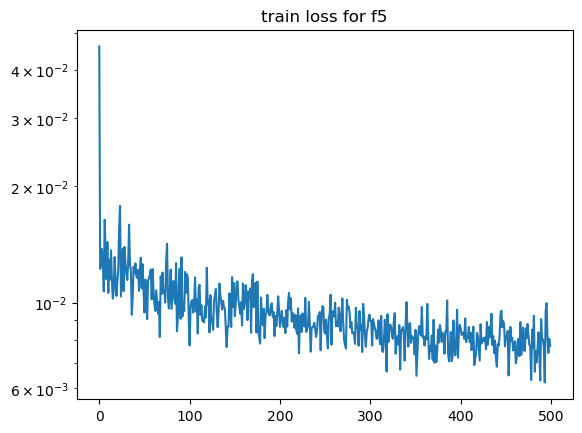

In [31]:
# prediction
with torch.no_grad():
    model_f5.eval()
    y_pred = model_f5(X_tensor_f5.unsqueeze(1))

final_loss = criterion_f5(y_pred, Z5_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f5[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f5, label='train loss')
plt.yscale('log')
plt.title('train loss for f5')
plt.savefig('figures/PMonNN_train_loss_f5.png')
plt.show()

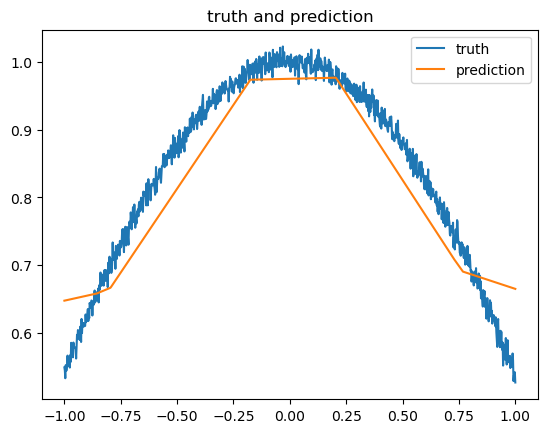

In [32]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f5, Z5_tensor, label='truth')
plt.plot(X_tensor_f5, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/PMonNN_truth_prediction_f5.png')
plt.show()

### 2.6 $f_6(x, y) = x^2 + y^2$: monotonic increasing in $x$  and $y$

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/336351469.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/336351469.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()


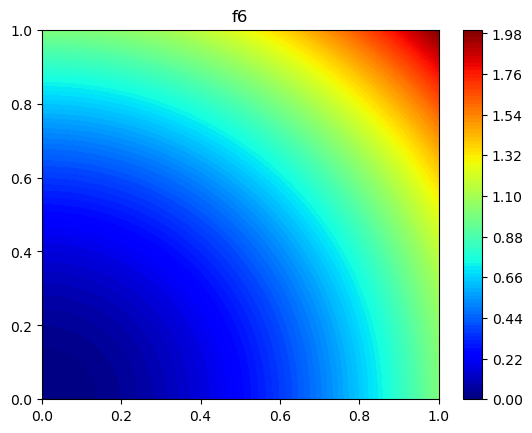

In [33]:
# define space
X_tensor_f6 = torch.linspace(0, 1, 100)
Y_tensor_f6 = torch.linspace(0, 1, 100)
X_tensor_f6_2D, Y_tensor_f6_2D = torch.meshgrid(X_tensor_f6, Y_tensor_f6)
Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))

X_tensor_2d = torch.cat((X_tensor_f6_2D.unsqueeze(2), Y_tensor_f6_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f6')
# plt.savefig('figures/f6.png')
plt.show()

In [34]:
# NN parameters
n_features_in = 2 # 2 variables in input
group_sizes = [4, 8, 16, 16, 8, 4] # number of neurons in each group
increasing_bool = [True, True] # increasing or decreasing
monotonic_bool = [True, True] # monotonic or not

# initial learning rate
LR = 1e-2

# defining the model
model_f6 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f6 = nn.MSELoss()
optimizer_f6 = torch.optim.Adam(model_f6.parameters(), lr=LR)
scheduler_f6 = torch.optim.lr_scheduler.StepLR(optimizer_f6, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

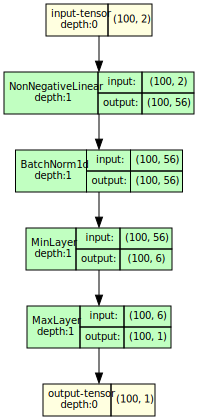

In [35]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f6, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="PMonNN_graph_f6", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [36]:
# training loop
EPOCHS = 500
BATCH_SIZE = 256

losses_f6 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f6.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_2d[idx], Z6_tensor[idx]

        # zero grad
        optimizer_f6.zero_grad()

        # forward pass
        output = model_f6(batch_x)

        # compute loss
        loss = criterion_f6(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f6.step()

    # update LR
    scheduler_f6.step()

    losses_f6.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f6[-1]:.7f} - LR {optimizer_f6.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:39<00:00, 12.60it/s, Loss 0.0016109 - LR 0.0023730]


Epoch 500 - train loss: 0.0016108831758174346
Epoch 500 - test loss: 0.0002863889676518738


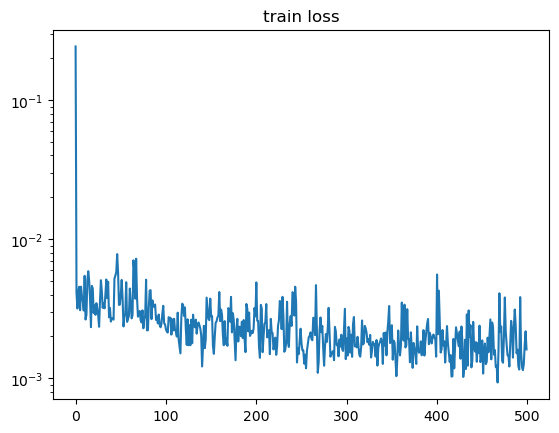

In [37]:
# prediction
with torch.no_grad():
    model_f6.eval()
    y_pred = model_f6(X_tensor_2d)

final_loss = criterion_f6(y_pred, Z6_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f6[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f6, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/PMonNN_train_loss_f6.png')
plt.show()

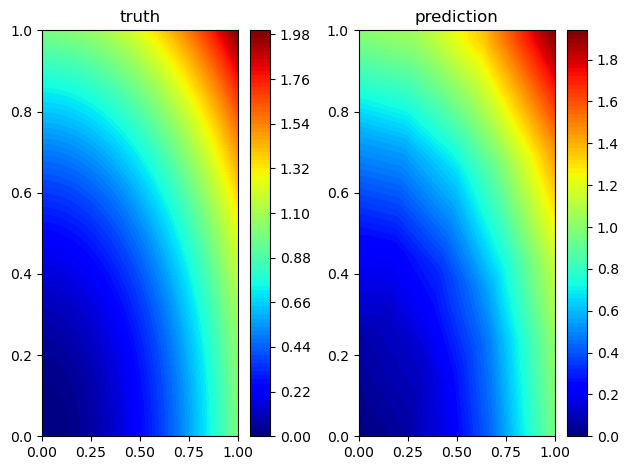

In [38]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/PMonNN_truth_prediction_f6.png')
plt.show()

### 2.7 $f_7(x, y) = x^3 + 0.5*sin(4*\pi*y)$: monotonic increasing in $x$ and non-monotonic in $y$

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/3490342334.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z7_tensor_2D = torch.tensor(f7(X_tensor_f7_2D, Y_tensor_f7_2D))
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/3490342334.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z7_tensor = torch.tensor(Z7_tensor_2D.ravel()).float()


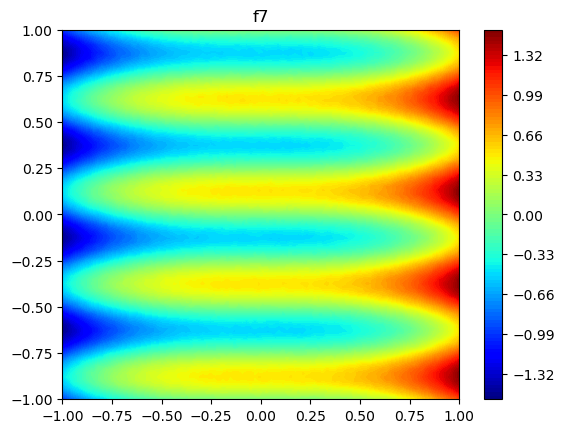

In [39]:
# define space
X_tensor_f7 = torch.linspace(-1, 1, 100)
Y_tensor_f7 = torch.linspace(-1, 1, 100)
X_tensor_f7_2D, Y_tensor_f7_2D = torch.meshgrid(X_tensor_f7, Y_tensor_f7)
Z7_tensor_2D = torch.tensor(f7(X_tensor_f7_2D, Y_tensor_f7_2D))

X_tensor_2d = torch.cat((X_tensor_f7_2D.unsqueeze(2), Y_tensor_f7_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z7_tensor = torch.tensor(Z7_tensor_2D.ravel()).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f7_2D, Y_tensor_f7_2D, Z7_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f7')
# plt.savefig('figures/f6.png')
plt.show()

In [40]:
# NN parameters
n_features_in = 2 # 2 variables in put
group_sizes = [8, 16, 32, 32, 64, 32, 32, 16, 8] # number of neurons in each group
increasing_bool = [True, None] # increasing or decreasing
monotonic_bool = [True, False] # monotonic or not

# initial learning rate
LR = 1e-2

# defining the model
model_f7 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f7 = nn.MSELoss()
optimizer_f7 = torch.optim.Adam(model_f7.parameters(), lr=LR)
scheduler_f7 = torch.optim.lr_scheduler.StepLR(optimizer_f7, step_size=100, gamma=0.75)
# cosine scheduler
# scheduler_f6 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_f6, T_max=100, eta_min=1e-6)
n_samples_train = X_tensor_2d.shape[0]

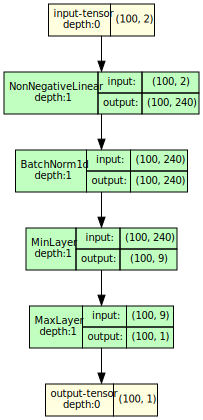

In [41]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f7, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="PMonNN_graph_f7", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [42]:
# training loop
EPOCHS = 1_000
BATCH_SIZE = 256

losses_f7 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f7.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_2d[idx], Z7_tensor[idx]

        # zero grad
        optimizer_f7.zero_grad()

        # forward pass
        output = model_f7(batch_x)

        # compute loss
        loss = criterion_f7(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f7.step()

    # update LR
    scheduler_f7.step()

    losses_f7.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f7[-1]:.7f} - LR {optimizer_f7.param_groups[0]['lr']:.7f}")
    

Epoch 999: 100%|██████████| 1000/1000 [01:46<00:00,  9.36it/s, Loss 0.0361984 - LR 0.0005631]


Epoch 1000 - train loss: 0.03619840417522937
Epoch 1000 - test loss: 0.012698691338300705


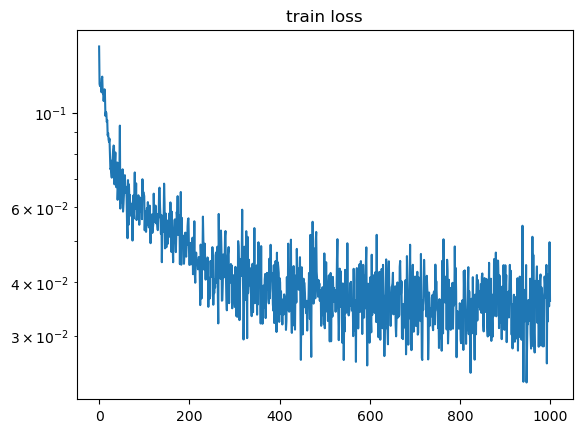

In [43]:
# prediction
with torch.no_grad():
    model_f7.eval()
    y_pred = model_f7(X_tensor_2d)

final_loss = criterion_f7(y_pred, Z7_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f7[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f7, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/PMonNN_train_loss_f6.png')
plt.show()

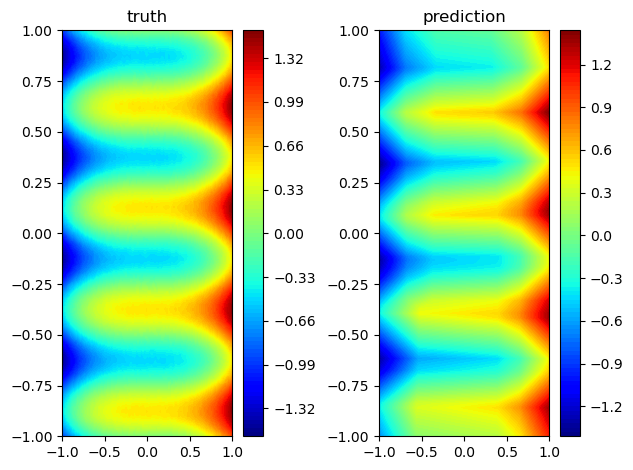

In [44]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f7_2D, Y_tensor_f7_2D, Z7_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f7_2D, Y_tensor_f7_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/PMonNN_truth_prediction_f6.png')
plt.show()

### 2.8 $f_8(x) = x^3 + x^2 + x + 1$: monotonic increasing in $x$, non-linear

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61152/3536570812.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z8_tensor = torch.tensor(f8(X_tensor_f8)).float()


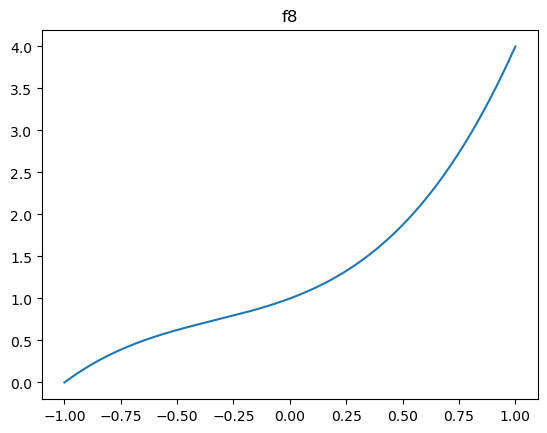

In [45]:
# define space
X_tensor_f8 = torch.linspace(-1, 1, 1000).float()
Z8_tensor = torch.tensor(f8(X_tensor_f8)).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f8.cpu().detach(), Z8_tensor.cpu().detach(), label='f8')
plt.title('f8')
# plt.savefig('figures/f2.png')
plt.show()

In [83]:
# NN parameters
n_features_in = 1 # only one variable
group_sizes = [8, 4, 16, 4, 8] # number of neurons in each group
increasing_bool = [True] # increasing or decreasing
monotonic_bool = [True] # monotonic or not

# initial learning rate
LR = 1e-2

# defining the model
model_f8 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f8 = nn.MSELoss()
optimizer_f8 = torch.optim.Adam(model_f8.parameters(), lr=LR)
# cosine scheduler
scheduler_f8 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_f8, T_max=100, eta_min=1e-6)

n_samples_train = X_tensor_f8.shape[0]

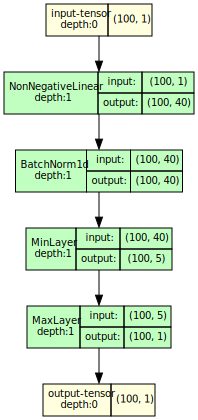

In [84]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f8, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="PMonNN_graph_f8", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [85]:
# training loop
EPOCHS = 300
BATCH_SIZE = 10

losses_f8 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f8.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_f8[idx], Z8_tensor[idx]

        # zero grad
        optimizer_f8.zero_grad()

        # forward pass
        output = model_f8(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f8(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f8.step()

    # update LR
    scheduler_f8.step()

    losses_f8.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f8[-1]:.7f} - LR {optimizer_f8.param_groups[0]['lr']:.7f}")
    

Epoch 299: 100%|██████████| 300/300 [00:26<00:00, 11.20it/s, Loss 0.1315655 - LR 0.0000010]


Epoch 300 - train loss: 0.13156547549180686
Epoch 300 - test loss: 0.029445888474583626


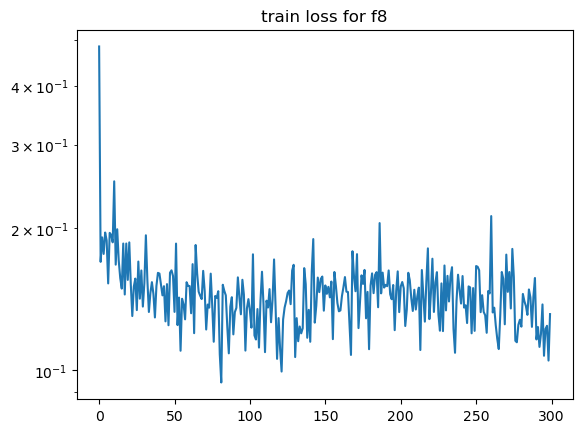

In [86]:
# prediction
with torch.no_grad():
    model_f8.eval()
    y_pred = model_f8(X_tensor_f8.unsqueeze(1))

final_loss = criterion_f8(y_pred, Z8_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f8[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f8, label='train loss')
plt.yscale('log')
plt.title('train loss for f8')
plt.savefig('figures/PMonNN_train_loss_f8.png')
plt.show()

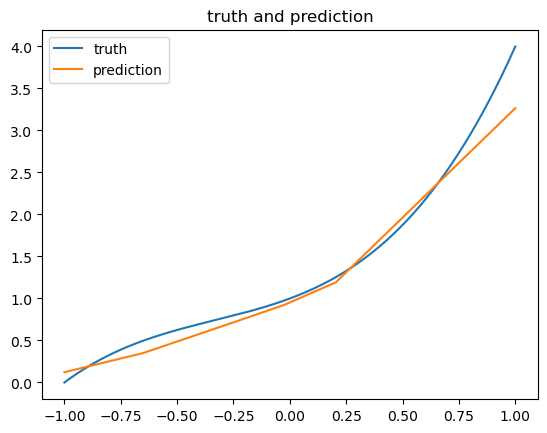

In [87]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f8, Z8_tensor, label='truth')
plt.plot(X_tensor_f8, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/PMonNN_truth_prediction_f8.png')
plt.show()